In [1]:
import yaggie
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Easy Sigmentation

- `yaggie` contains a simple implementation of [this paper](https://ieeexplore.ieee.org/document/1048295), which can be easily used to segment cellular images.
- Segmentation from a noisy image is acturally not easy. There are many parameter to play with.

## Load data

Firstly, we use the lif file reader to load the image as a numpy array:

/usr/local/lib/python3.7/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


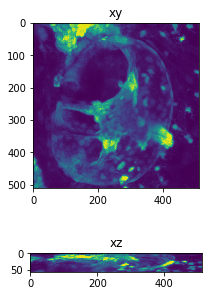

In [2]:
lif_file_path = '../zebrabow.lif'
reader = yaggie.read_lif.Reader(lif_file_path)
series = reader.getSeries()
data = series[7].getFrame(channel=0).astype(np.float64)
data = ndimage.zoom(data, 0.5)
plt.subplot(211).imshow(data.max(-1).T)
plt.title('xy')
#plt.axis('off')
plt.subplot(212).imshow(data.max(1).T)
plt.title('xz')
#plt.axis('off')
plt.gcf().set_size_inches(3, 5)
plt.tight_layout()
plt.show()

## Use filter

The data seems noisy, I would use a [median filter](https://en.wikipedia.org/wiki/Median_filter) to make it better

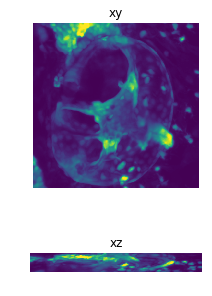

In [3]:
data_denoise = data.copy()
#data_denoise = ndimage.gaussian_filter(data_denoise, 1)
data_denoise = ndimage.median_filter(data_denoise, 4)
plt.subplot(211).imshow(data_denoise.max(-1).T)
plt.title('xy')
plt.axis('off')
plt.subplot(212).imshow(data_denoise.max(1).T)
plt.title('xz')
plt.axis('off')
plt.gcf().set_size_inches(3, 5)
plt.tight_layout()
plt.show()

## It can also be a good idea to remove dim voxel with a threshold

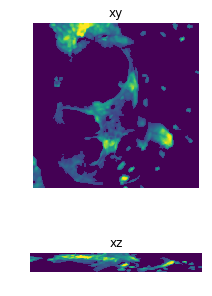

In [4]:
threshold_runner = yaggie.threshold.HysteresisEngine()
data_processed = threshold_runner.run(data_denoise)

plt.subplot(211).imshow(data_processed.max(-1).T)
plt.title('xy')
plt.axis('off')
plt.subplot(212).imshow(data_processed.max(1).T)
plt.title('xz')
plt.axis('off')
plt.gcf().set_size_inches(3, 5)
plt.tight_layout()
plt.show()

# Segmentation

## Run CHEF

there is a paramter, `blur`, which have to be turned manually

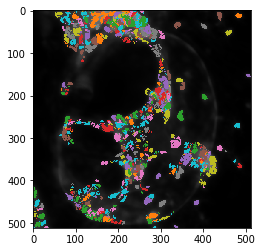

In [5]:
blur = 1.2
segmenter = yaggie.engine.segment.CHEFEngine(blur)
labels = segmenter.run(data_processed)

image = yaggie.utility.label_to_2d_image(labels, alpha=1)
plt.imshow(data_denoise.mean(-1).T, cmap='gray')
plt.imshow(image)
plt.show()

## Remove small features

we often get small noise in the segmentation result, we can filter them out with `yaggie.engine.segment.Label

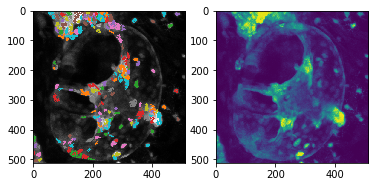

In [6]:
minimum_voxel = 200
label_engine = yaggie.engine.segment.LabelEngine(minimum_voxel)
labels_denoise = label_engine.run(labels > 0)

image = yaggie.utility.label_to_2d_image(labels_denoise, alpha=1)
plt.subplot(121).imshow(data.max(-1).T, cmap='gray')
plt.gca().imshow(image)
plt.subplot(122).imshow(data.max(-1).T)
plt.show()

Look, we get results! Are they reliable? Well, ....